For a \$100MM pool of 6.50\% WAC 30yr loans with 70bps servicing/g-fee, 

Create a Sequential structure with 4 tranches : 


A: \$45MM,


B: \$25MM,


C: \$20MM,


D: \$10MM


For ten PSA scenarios (from 50 PSA to 500 PSA in increments of 50), calculate and graph WAL for each tranche (x-axis: PSA speed, y-axis: WAL)



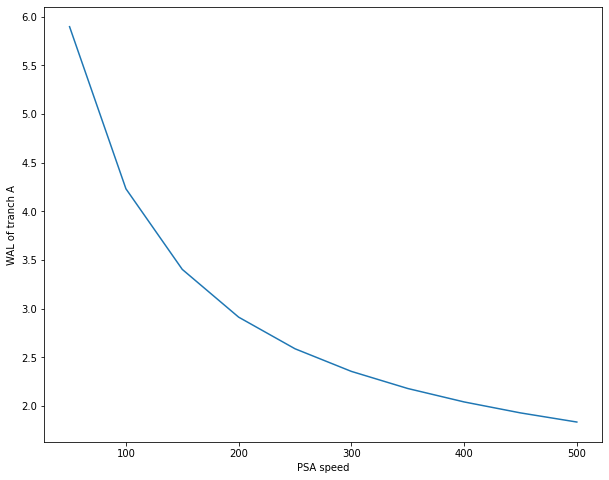

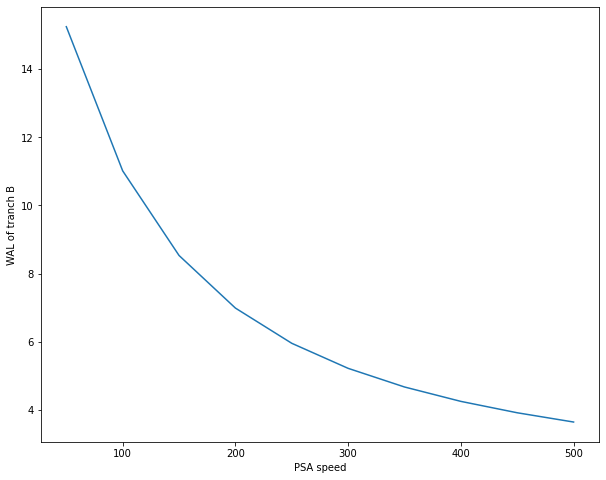

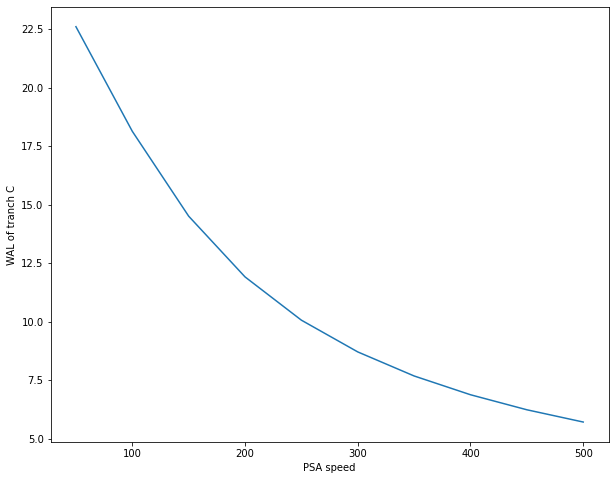

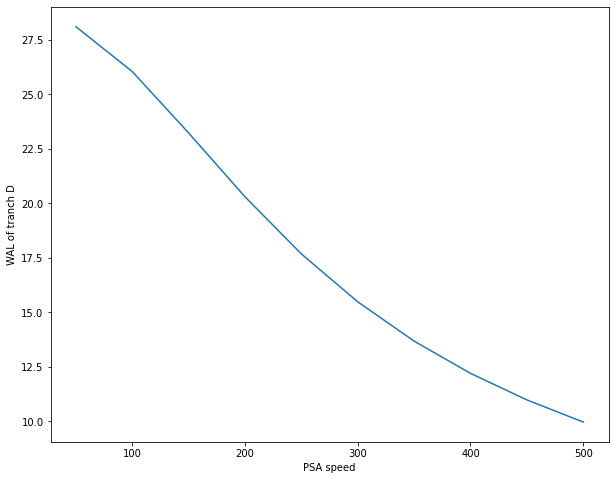

In [1]:
def get_SMM(PSA, month):
    factor = PSA / 100
    if month < 30:
        temp = 0.002 * month
    else:
        temp = 0.06
    CPR = temp * factor
    SMM = 1 - (1 - CPR) ** (1 / 12)
    return SMM

def get_WAL(arr, initial_principal):
    # arr in the form of [0,0,1,2,3,0,0,..0]
    last = np.where(arr != 0)[0][-1] + 1
    arr = arr[:last]
    return sum(arr * np.linspace(1,len(arr),len(arr))) / initial_principal / 12
    

import numpy as np

c = 0.065 / 12
fee = 0.007
m = 30 * 12

WAL_A = []
WAL_B = []
WAL_C = []
WAL_D = []


for PSA in range(50, 501, 50):
    i = 0
    initial_principal = 100000000
    end_principal = [initial_principal]
    tranches = np.array(
    [0.45 * initial_principal, 0.25 * initial_principal, 0.2 * initial_principal, 0.1 * initial_principal])
    tranches_his = [tranches]
    while end_principal[-1] > 0.1:
        smm = get_SMM(PSA, i)
        scheduled_interest = end_principal[-1] * (c - fee / 12)
        mthly_pymt = c * (1 + c) ** (m-i) / ((1 + c) ** (m-i) - 1) * end_principal[-1]
        actual_pymt = mthly_pymt + smm * end_principal[-1]
        actual_prin_pymt = actual_pymt - scheduled_interest
        if end_principal[-1] - actual_prin_pymt < 0:
            actual_prin_pymt = end_principal[-1]
            end_principal.append(0)
        else:
            end_principal.append(end_principal[-1] - actual_prin_pymt)
        j = 0
        temp = tranches_his[-1].copy()
        while actual_prin_pymt > 0.1:
            if actual_prin_pymt > temp[j]:
                actual_prin_pymt -= temp[j]
                temp[j] = 0
            else:
                temp[j] -= actual_prin_pymt
                actual_prin_pymt = 0
            j += 1
        tranches_his.append(temp)
        i += 1
    tranches_his = np.array(tranches_his)
    principal_pymt_his = tranches_his[:-1,:] - tranches_his[1:,:]
    A_principal_pymt = principal_pymt_his[:,0]
    B_principal_pymt = principal_pymt_his[:,1]
    C_principal_pymt = principal_pymt_his[:,2]
    D_principal_pymt = principal_pymt_his[:,3]
    WAL_A.append(get_WAL(A_principal_pymt, tranches[0]))
    WAL_B.append(get_WAL(B_principal_pymt, tranches[1]))
    WAL_C.append(get_WAL(C_principal_pymt, tranches[2]))
    WAL_D.append(get_WAL(D_principal_pymt, tranches[3]))
    
d = {'A':WAL_A,'B':WAL_B,'C':WAL_C,'D':WAL_D}

import matplotlib.pyplot as plt

for name in ['A','B','C','D']:
    plt.figure(figsize=(10,8))
    plt.plot(range(50,501,50),d[name])
    plt.xlabel('PSA speed')
    plt.ylabel('WAL of tranch '+ name)
    plt.show()

List the tranches in declining order of **sensitivity (of WAL as a function of PSA)** and explain why these tranches are in this order.

From the plots, we can see that the sensitivity of WAL as a function of PSA in declining order is: **D>C>B>A**\
**Explanation**:\
When prepayment speeds increase (due to factors like declining interest rates or economic conditions), mortgages in the pool are paid off faster. This has a greater impact on the timing of principal payments for lower priority tranches because they receive payments after higher priority tranches. Faster prepayment speeds mean that principal payments are received sooner than expected. Lower priority tranches, which receive payments later in the sequence, experience a larger shift in the timing of their cash flows compared to higher priority tranches. So lower priority tranches are more exposed to the effects of prepayments being accelerated, leading to greater variability in their average life. As a result, the average timing of principal payments (WAL) for lower priority tranches becomes more sensitive to changes in prepayment speeds (PSA).


Instead create a PAC structure with one PAC (with 100 and 250 PSA bands), and one Companion, assuming they pay the same coupon. (To calculate the initial notional of the PAC, sum up the smaller of each month’s principal cash flows under 100 PSA and under 250 PSA.  The Companion’ notional will be \$100MM – the PAC notional.)


In [2]:
import matplotlib.pyplot as plt

def get_SMM(PSA, month):
    factor = PSA / 100
    if month < 30:
        temp = 0.002 * month
    else:
        temp = 0.06
    CPR = temp * factor
    SMM = 1 - (1 - CPR) ** (1 / 12)
    return SMM


c = 0.065 / 12
fee = 0.007
m = 30 * 12
initial_principal = 100000000
end_principal_1 = [initial_principal]
end_principal_2 = [initial_principal]

pac_notional = 0
pac_schedule_his = []
prin_pymt_1 = []
prin_pymt_2 = []
i = 0
while max(end_principal_1[-1],end_principal_2[-1])  > 0.1:
    smm_1 = get_SMM(100, i)
    smm_2 = get_SMM(250, i)
    scheduled_interest_1 = end_principal_1[-1] * (c - fee / 12)
    scheduled_interest_2 = end_principal_2[-1] * (c - fee / 12)
    mthly_pymt_1 = c * (1 + c) ** (m-i) / ((1 + c) ** (m-i) - 1) * end_principal_1[-1]
    mthly_pymt_2 = c * (1 + c) ** (m-i) / ((1 + c) ** (m-i) - 1) * end_principal_2[-1]
    actual_pymt_1 = mthly_pymt_1 + smm_1 * end_principal_1[-1]
    actual_pymt_2 = mthly_pymt_2 + smm_2 * end_principal_2[-1]
    actual_prin_pymt_1 = actual_pymt_1 - scheduled_interest_1
    actual_prin_pymt_2 = actual_pymt_2 - scheduled_interest_2
    if end_principal_1[-1] - actual_prin_pymt_1 < 0:
        actual_prin_pymt_1 = end_principal_1[-1]
        end_principal_1.append(0)
    else:
        end_principal_1.append(end_principal_1[-1] - actual_prin_pymt_1)
    if end_principal_2[-1] - actual_prin_pymt_2 < 0:
        actual_prin_pymt_2 = end_principal_2[-1]
        end_principal_2.append(0)
    else:
        end_principal_2.append(end_principal_2[-1] - actual_prin_pymt_2)
    prin_pymt_1.append(actual_prin_pymt_1)
    prin_pymt_2.append(actual_prin_pymt_2)
    pac_schedule_his.append(min(actual_prin_pymt_1, actual_prin_pymt_2))
    pac_notional += min(actual_prin_pymt_1, actual_prin_pymt_2)
    i += 1

comp_notional = initial_principal - pac_notional
print('Initial notional of PAC: ', pac_notional)
print('Initial notional of Companion: ', comp_notional)

Initial notional of PAC:  72771340.1874836
Initial notional of Companion:  27228659.812516406


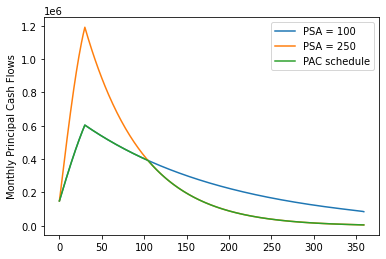

In [3]:
plt.plot(prin_pymt_1,label='PSA = 100')
plt.plot(prin_pymt_2,label='PSA = 250')
plt.plot(pac_schedule_his,label='PAC schedule')
plt.legend()
plt.ylabel('Monthly Principal Cash Flows')
plt.show()

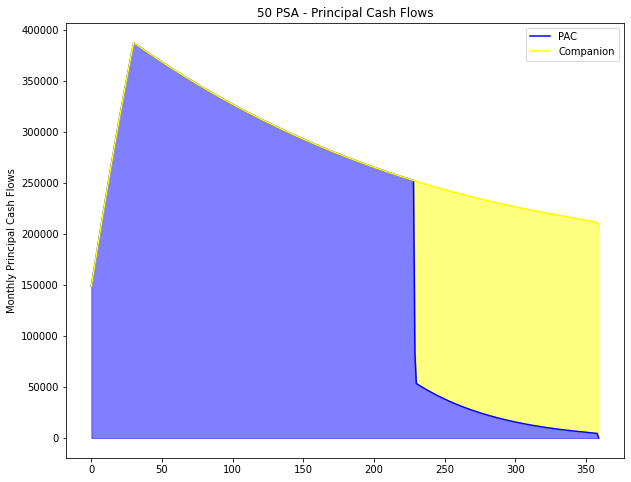

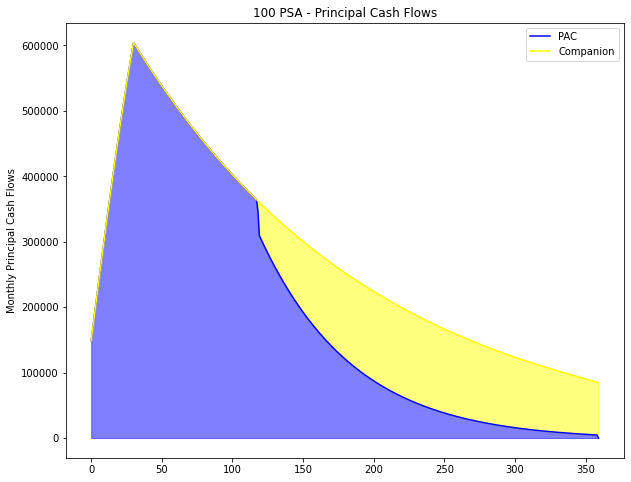

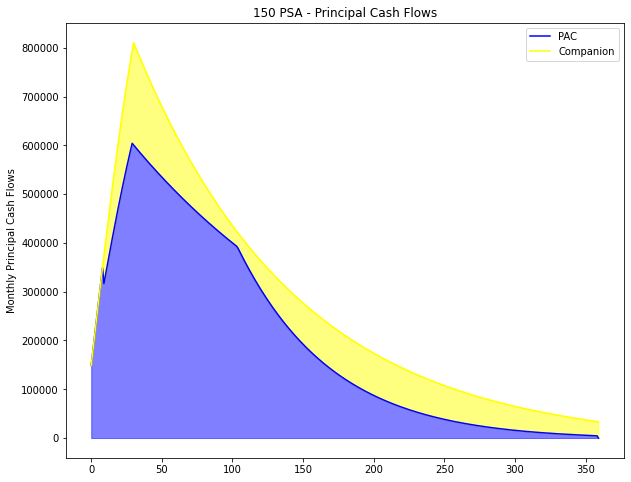

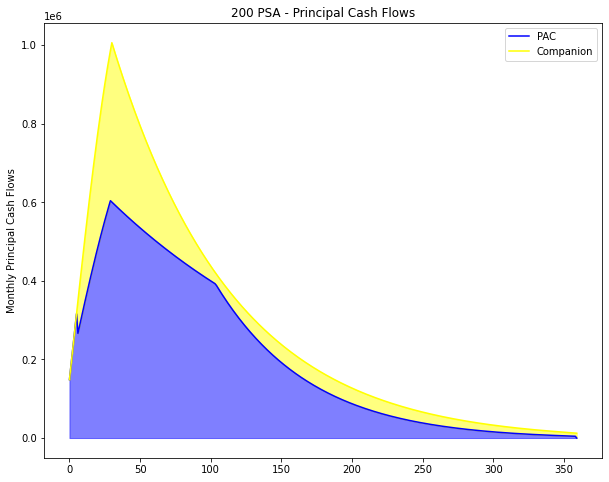

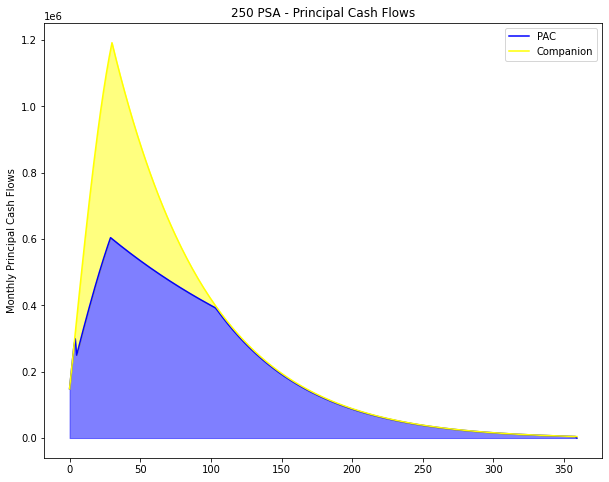

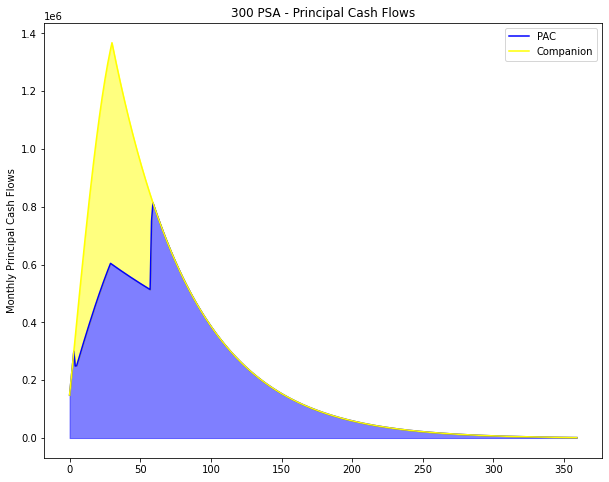

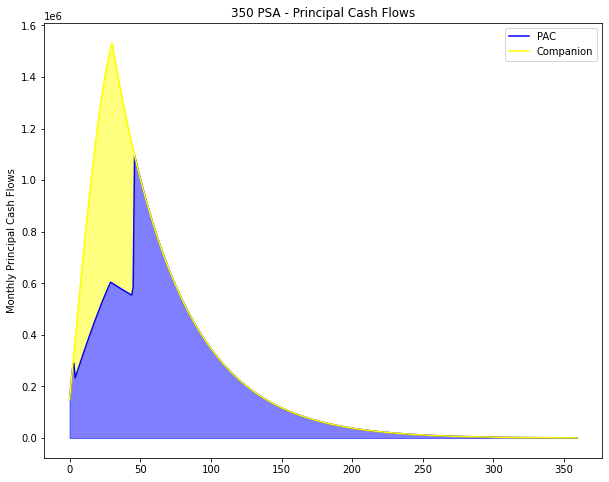

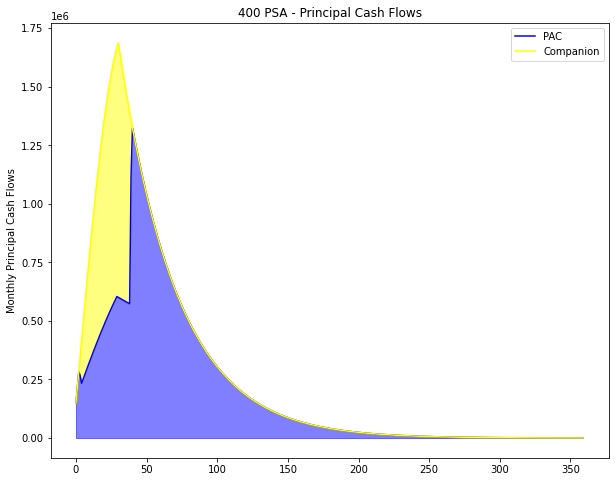

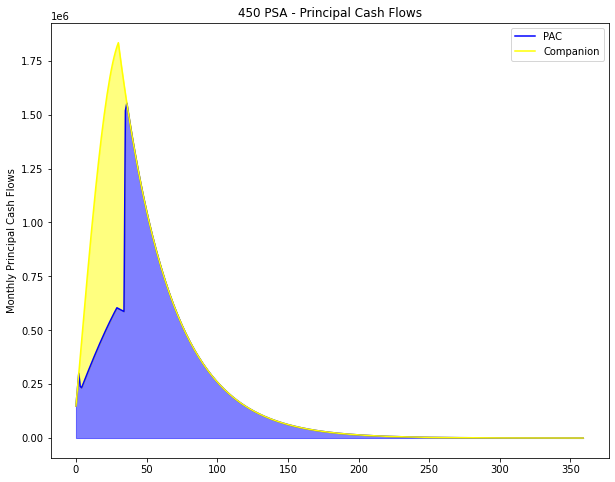

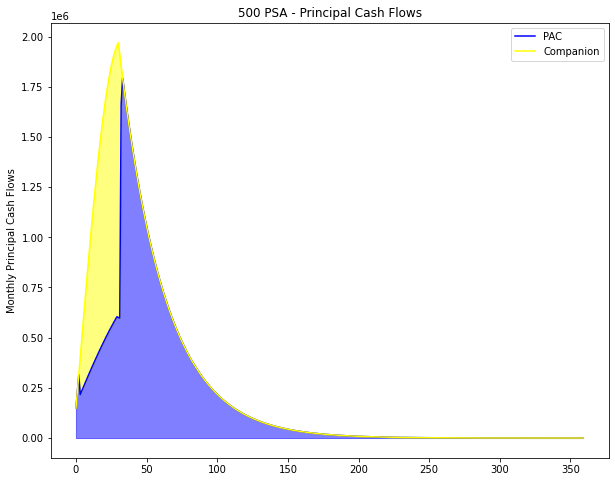

In [4]:
import numpy as np

def my_plot(PSA, comp_notional):
    
    end_principal = [initial_principal]
    pac_prin_his = []
    companion_prin_his = []

    i = 0
    while end_principal[-1] > 0.1:
        smm = get_SMM(PSA, i)
        scheduled_interest = end_principal[-1] * (c - fee / 12)
        mthly_pymt = c * (1 + c) ** (m-i) / ((1 + c) ** (m-i) - 1) * end_principal[-1]
        actual_pymt = mthly_pymt + smm * end_principal[-1]
        actual_prin_pymt = actual_pymt - scheduled_interest
        if end_principal[-1] - actual_prin_pymt < 0:
            actual_prin_pymt = end_principal[-1]
            end_principal.append(0)
        else:
            end_principal.append(end_principal[-1] - actual_prin_pymt)
        
        if comp_notional > 0:
            if actual_prin_pymt >= pac_schedule_his[i]:
                if sum(pac_prin_his) + actual_prin_pymt > sum(pac_schedule_his[:i+2]):
                    to_comp = sum(pac_prin_his) + actual_prin_pymt - sum(pac_schedule_his[:i+2])
                    if comp_notional >= to_comp:
                        pac_prin_his.append(actual_prin_pymt - to_comp)
                        companion_prin_his.append(to_comp)
                        comp_notional -= to_comp
                    else:
                        companion_prin_his.append(comp_notional)
                        pac_prin_his.append(actual_prin_pymt - comp_notional)
                        comp_notional = 0
                else:
                    pac_prin_his.append(actual_prin_pymt)
                    companion_prin_his.append(0)
            else:
                pac_prin_his.append(actual_prin_pymt)
                companion_prin_his.append(0)
        else:
            pac_prin_his.append(actual_prin_pymt)
            companion_prin_his.append(0)   
        i+=1
    pac_prin_his = np.array(pac_prin_his)
    companion_prin_his = np.array(companion_prin_his)
    total_prin = pac_prin_his + companion_prin_his
    plt.figure(figsize=(10,8))
    plt.plot(pac_prin_his,label='PAC', color = 'blue')
    plt.plot(total_prin, label='Companion',color='yellow')
    plt.fill_between(range(360), pac_prin_his, color='blue', alpha=0.5)
    plt.fill_between(range(360), pac_prin_his, total_prin, color='yellow', alpha=0.5)
    plt.legend()
    plt.ylabel('Monthly Principal Cash Flows')
    plt.title(str(PSA)+' PSA - Principal Cash Flows')
    plt.show()
                
for PSA in range(50,501,50):               
    my_plot(PSA,comp_notional)            

#### We can see that the PAC busts for PSA larger than or equal to 300, since under such a rapid prepayment, the companion are paid off quickly and there is only PAC left, hence it loses the protection from the Companion and all the prepaid principle go directly into PAC, which makes it bust.